In [1]:
#! pip install polars
#! pip install fastexcel

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
data = pl.read_excel("Data/CleanData.xlsx").select("Date", "CUSIP", "asset_type", "maturity_date", "credit_rating", "current_yield", "ytm", "modified_duration")
data = data.filter(pl.col('asset_type') == 'Credit')
data

Date,CUSIP,asset_type,maturity_date,credit_rating,current_yield,ytm,modified_duration
date,str,str,date,str,f64,f64,f64
2009-07-01,"""74815HBZ4_0""","""Credit""",2026-01-30,"""Aa2""",5.595907,5.1196,6.992115
2009-07-01,"""59562VAM9_0""","""Credit""",2036-04-01,"""Baa1""",5.883715,5.8191,13.169137
2009-07-01,"""002824AV2_0""","""Credit""",2039-04-01,"""Aa2""",5.51503,5.4001,14.24712
2009-07-08,"""59562VAM9_0""","""Credit""",2036-04-01,"""Baa1""",6.112092,6.2979,12.700469
2009-07-08,"""002824AV2_0""","""Credit""",2039-04-01,"""Aa2""",5.561761,5.65,13.924144
…,…,…,…,…,…,…,…
2024-11-13,"""00217GAC7_0""","""Credit""",2052-02-29,"""Baa2""",5.605201,6.3089,13.684314
2024-11-13,"""896516AA9_0""","""Credit""",2045-12-01,"""Aa3""",4.844503,5.5075,12.722053
2024-11-13,"""12189LBE0_0""","""Credit""",2050-02-15,"""Aa3""",4.642152,5.434,14.471478


- choose yield dynamically (maturity <= 1: current yield; maturity > 1: ytm)

In [3]:
data = data.with_columns((pl.when(pl.col("maturity_date") - pl.col("Date") < 365 * 24 * 60 * 60).
                          then(pl.col("current_yield")).otherwise(pl.col("ytm"))).alias("adjusted_yield"))
#data

- delta_y (interest rate) and excess return

In [4]:
data = data.sort("Date", "CUSIP").with_columns((pl.col("adjusted_yield") - pl.col("adjusted_yield").
                                                shift(1).over("CUSIP")).alias("delta_y"))
data = data.with_columns((-pl.col("modified_duration") * pl.col("delta_y")).alias("excess_return"))
data = data.filter(pl.col('adjusted_yield') < pl.col('adjusted_yield').quantile(0.99), pl.col('adjusted_yield') > pl.col('adjusted_yield').quantile(0.01))

- rolling to get sigma

In [5]:
data = data.with_columns(pl.col("delta_y").rolling_std(36).over("CUSIP").alias("rate_volatility"), 
                         pl.col("excess_return").rolling_std(36).over("CUSIP").alias("excess_return_volatility")
                        ).drop_nulls()
data

Date,CUSIP,asset_type,maturity_date,credit_rating,current_yield,ytm,modified_duration,adjusted_yield,delta_y,excess_return,rate_volatility,excess_return_volatility
date,str,str,date,str,f64,f64,f64,f64,f64,f64,f64,f64
2010-03-17,"""002824AV2_0""","""Credit""",2039-04-01,"""Aa2""",5.533376,5.42,13.83507,5.42,-0.12,1.660207,0.109103,1.531642
2010-03-17,"""59562VAM9_0""","""Credit""",2036-04-01,"""Baa1""",5.966198,5.9229,12.687662,5.9229,-0.118,1.497145,0.152044,1.959943
2010-03-17,"""74815HBZ4_0""","""Credit""",2026-01-30,"""Aa2""",5.814587,5.4735,5.5833,5.4735,-0.1179,0.658273,0.207405,1.235679
2010-03-24,"""002824AV2_0""","""Credit""",2039-04-01,"""Aa2""",5.652341,5.57,13.637399,5.57,0.15,-2.045611,0.103718,1.455537
2010-03-24,"""59562VAM9_0""","""Credit""",2036-04-01,"""Baa1""",6.084719,6.0739,12.518228,6.0739,0.151,-1.890253,0.131102,1.697322
…,…,…,…,…,…,…,…,…,…,…,…,…
2024-11-13,"""896516AA9_0""","""Credit""",2045-12-01,"""Aa3""",4.844503,5.5075,12.722053,5.5075,0.0913,-1.161524,0.128911,1.69697
2024-11-13,"""91159HJN1_0""","""Credit""",2034-06-12,"""A2""",5.598318,5.3394,6.408492,5.3394,-0.0788,0.50499,0.132001,0.870704
2024-11-13,"""913017BT5_0""","""Credit""",2042-06-01,"""Baa1""",4.989028,5.5654,11.188636,5.5654,0.0164,-0.183497,0.118769,1.361624


#### plot time series with sigma_y

In [6]:
low_threshold = data["adjusted_yield"].quantile(0.33)
high_threshold = data["adjusted_yield"].quantile(0.66)
low_threshold, high_threshold

(2.987400054931641, 4.673200130462646)

In [7]:
low_data = data.filter(pl.col("adjusted_yield") <= low_threshold)
medium_data = data.filter((pl.col("adjusted_yield") > low_threshold) & (pl.col("adjusted_yield") <= 
                                                                                  high_threshold))
high_data = data.filter(pl.col("adjusted_yield") > high_threshold)

In [8]:
low_data_pd = low_data.to_pandas()
medium_data_pd = medium_data.to_pandas()
high_data_pd = high_data.to_pandas()

low_mean = low_data_pd.groupby("Date")["rate_volatility"].mean()
medium_mean = medium_data_pd.groupby("Date")["rate_volatility"].mean()
high_mean = high_data_pd.groupby("Date")["rate_volatility"].mean()

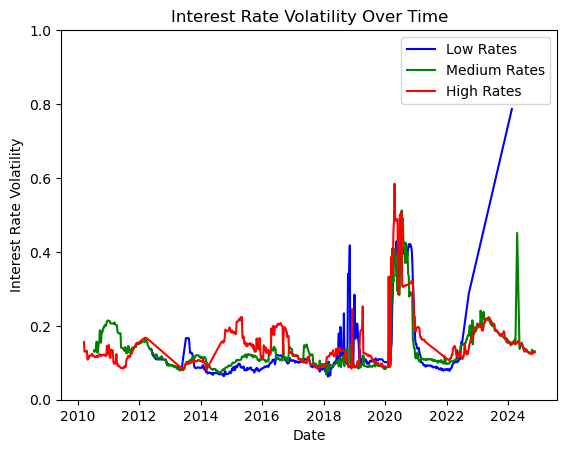

In [9]:
plt.plot(low_mean.index, low_mean.values, label="Low Rates", color="blue")
plt.plot(medium_mean.index, medium_mean.values, label="Medium Rates", color="green")
plt.plot(high_mean.index, high_mean.values, label="High Rates", color="red")
plt.xlabel("Date")
plt.ylabel("Interest Rate Volatility")
plt.title("Interest Rate Volatility Over Time")
plt.legend(loc="upper right")
plt.ylim(0.0, 1.0) 
plt.show()

- plot excess return with duration (whole time series)

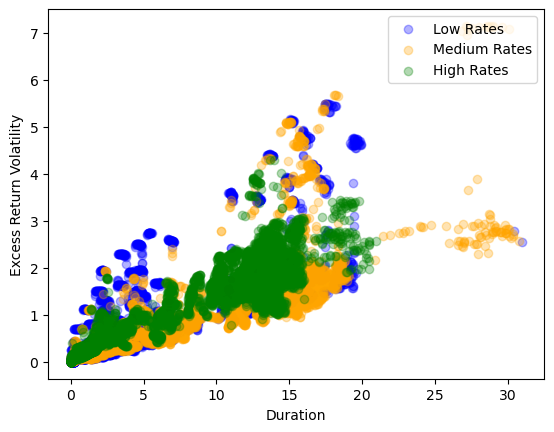

In [10]:
plt.scatter(low_data_pd["modified_duration"], low_data_pd["excess_return_volatility"], color="blue", alpha=0.3, label="Low Rates")
plt.scatter(medium_data_pd["modified_duration"], medium_data_pd["excess_return_volatility"], color="orange", alpha=0.3, label="Medium Rates")
plt.scatter(high_data_pd["modified_duration"], high_data_pd["excess_return_volatility"], color="green", alpha=0.3, label="High Rates")
plt.xlabel("Duration")
plt.ylabel("Excess Return Volatility")
plt.legend(loc="upper right")
plt.show()

- plot excess return with duration (removed covid time series data)

In [12]:
low_data_filt = low_data.filter(~(pl.col('Date').is_between(datetime.strptime('1/1/2020', '%m/%d/%Y'), datetime.strptime('1/1/2021', '%m/%d/%Y'))))
medium_data_filt = medium_data.filter(~(pl.col('Date').is_between(datetime.strptime('1/1/2020', '%m/%d/%Y'), datetime.strptime('1/1/2021', '%m/%d/%Y'))))
high_data_filt = high_data.filter(~(pl.col('Date').is_between(datetime.strptime('1/1/2020', '%m/%d/%Y'), datetime.strptime('1/1/2021', '%m/%d/%Y'))))

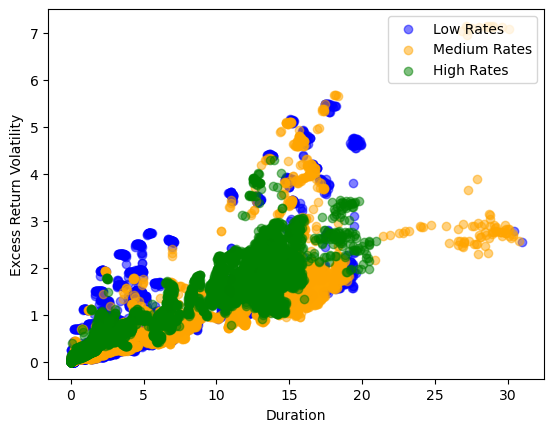

In [13]:
plt.scatter(low_data["modified_duration"], low_data["excess_return_volatility"], color="blue", alpha=0.5, label="Low Rates")
plt.scatter(medium_data["modified_duration"], medium_data["excess_return_volatility"], color="orange", alpha=0.5, label="Medium Rates")
plt.scatter(high_data["modified_duration"], high_data["excess_return_volatility"], color="green", alpha=0.5, label="High Rates")
plt.xlabel("Duration")
plt.ylabel("Excess Return Volatility")
plt.legend(loc="upper right")
plt.show()